# Data Analysis

## Setup

In [1]:
import os
import sys
from os.path import join, exists, expanduser
from datetime import datetime

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

import git
import time

git_repo = git.Repo(os.getcwd(), search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")
sys.path.append(join(git_root, "src", "red-sea-monitoring"))
from utils import *

# For plotting
from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format, comma_format, percent_format
import plotnine

plotnine.options.figure_size = (10, 8)

output_dir = (
    r"C:\Users\WB514197\WBG\Development Data Partnership - Red Sea Maritime Monitoring"
)
charts_dir = join(git_root, "reports")

In [2]:
df = pd.read_parquet(join(expanduser("~"), 'tmp', 'ais', 'portcalls_v5.parquet'))
len(df)

1761090

In [3]:
df.head(3)

,mmsi,imo,vessel_name,route_group,length,width,longitude,latitude,departure_longitude,departure_latitude,...,prev_port,prev_country,travel_distance,end_id,end_port_dist,start_id,start_port_dist,sea_route,distance,route
0,205217890,0,BUKA,1,80.0,10.0,4.362735,51.203493,4.318333,51.308333,...,Port of Rouen,France,305.029634,2866,48565.348803,3945,84525.171571,True,212.658524,None
1,205217890,0,BUKA,2,80.0,10.0,1.083920,49.438548,1.083943,49.438557,...,Antwerp,Belgium,305.020008,3945,84549.425838,2866,48565.348803,True,233.556733,None
2,205217890,0,BUKA,3,80.0,10.0,4.941667,52.381667,4.941667,52.381667,...,Port of Rouen,France,425.100535,2815,50183.122272,3945,84549.425838,True,538.442897,None


In [4]:
df.arrival_dt_pos_utc = pd.to_datetime(df.arrival_dt_pos_utc)

In [5]:
df = df.loc[df.arrival_dt_pos_utc>="2023-02-01"].copy()
df_ref = df.loc[df.arrival_dt_pos_utc<'2023-10-01'].copy()

## Get Vessels that crossed Red Sea in Reference Period

In [6]:
aois = ['Bab el-Mandeb Strait', 'Suez Canal']

In [7]:
df_sel = df.loc[(df.prev_port.isin(aois)) | (df.Port.isin(aois))].copy()

In [8]:
unique_vessels_red_sea = list(set(df_sel.unique_id))
unique_vessels = list(set(df.unique_id))
len(unique_vessels_red_sea) / len(unique_vessels)

0.1230031095391257

In [9]:
df2 = df.loc[df.unique_id.isin(unique_vessels_red_sea)].copy()

In [10]:
len(df2) / len(df)

0.1564102395245071

Select only Cargo and Tanker for reporting

In [11]:
types_sel = ['Cargo', 'Tanker']
df2 = df2[df2['vessel_type'].isin(types_sel)].copy()

In [12]:
len(df2) / len(df)

0.1481514963022742

Filter out short trips

In [13]:
df2 = df2.loc[df2.time_travel>1].copy()

In [14]:
df2.loc[:, "ymd"] = df2.apply(lambda x: datetime(year=x['year'], month=x['month'], day=1), axis=1)

In [15]:
df_cape = df2.loc[(df2.Port=='Cape of Good Hope') | (df2.prev_port=='Cape of Good Hope')].copy()
df_bab = df2.loc[(df2.Port=='Bab el-Mandeb Strait') | (df2.prev_port=='Bab el-Mandeb Strait')].copy()
df3 = pd.concat([df_cape, df_bab])
group_cols = ['ymd', 'vessel_type']
data_cols = ['time_travel', 'distance']
df_agg = df3.groupby(group_cols)[data_cols].sum().reset_index()
df_agg_cape = df_cape.groupby(group_cols)[data_cols].sum().reset_index()
df_agg_bab = df_bab.groupby(group_cols)[data_cols].sum().reset_index()

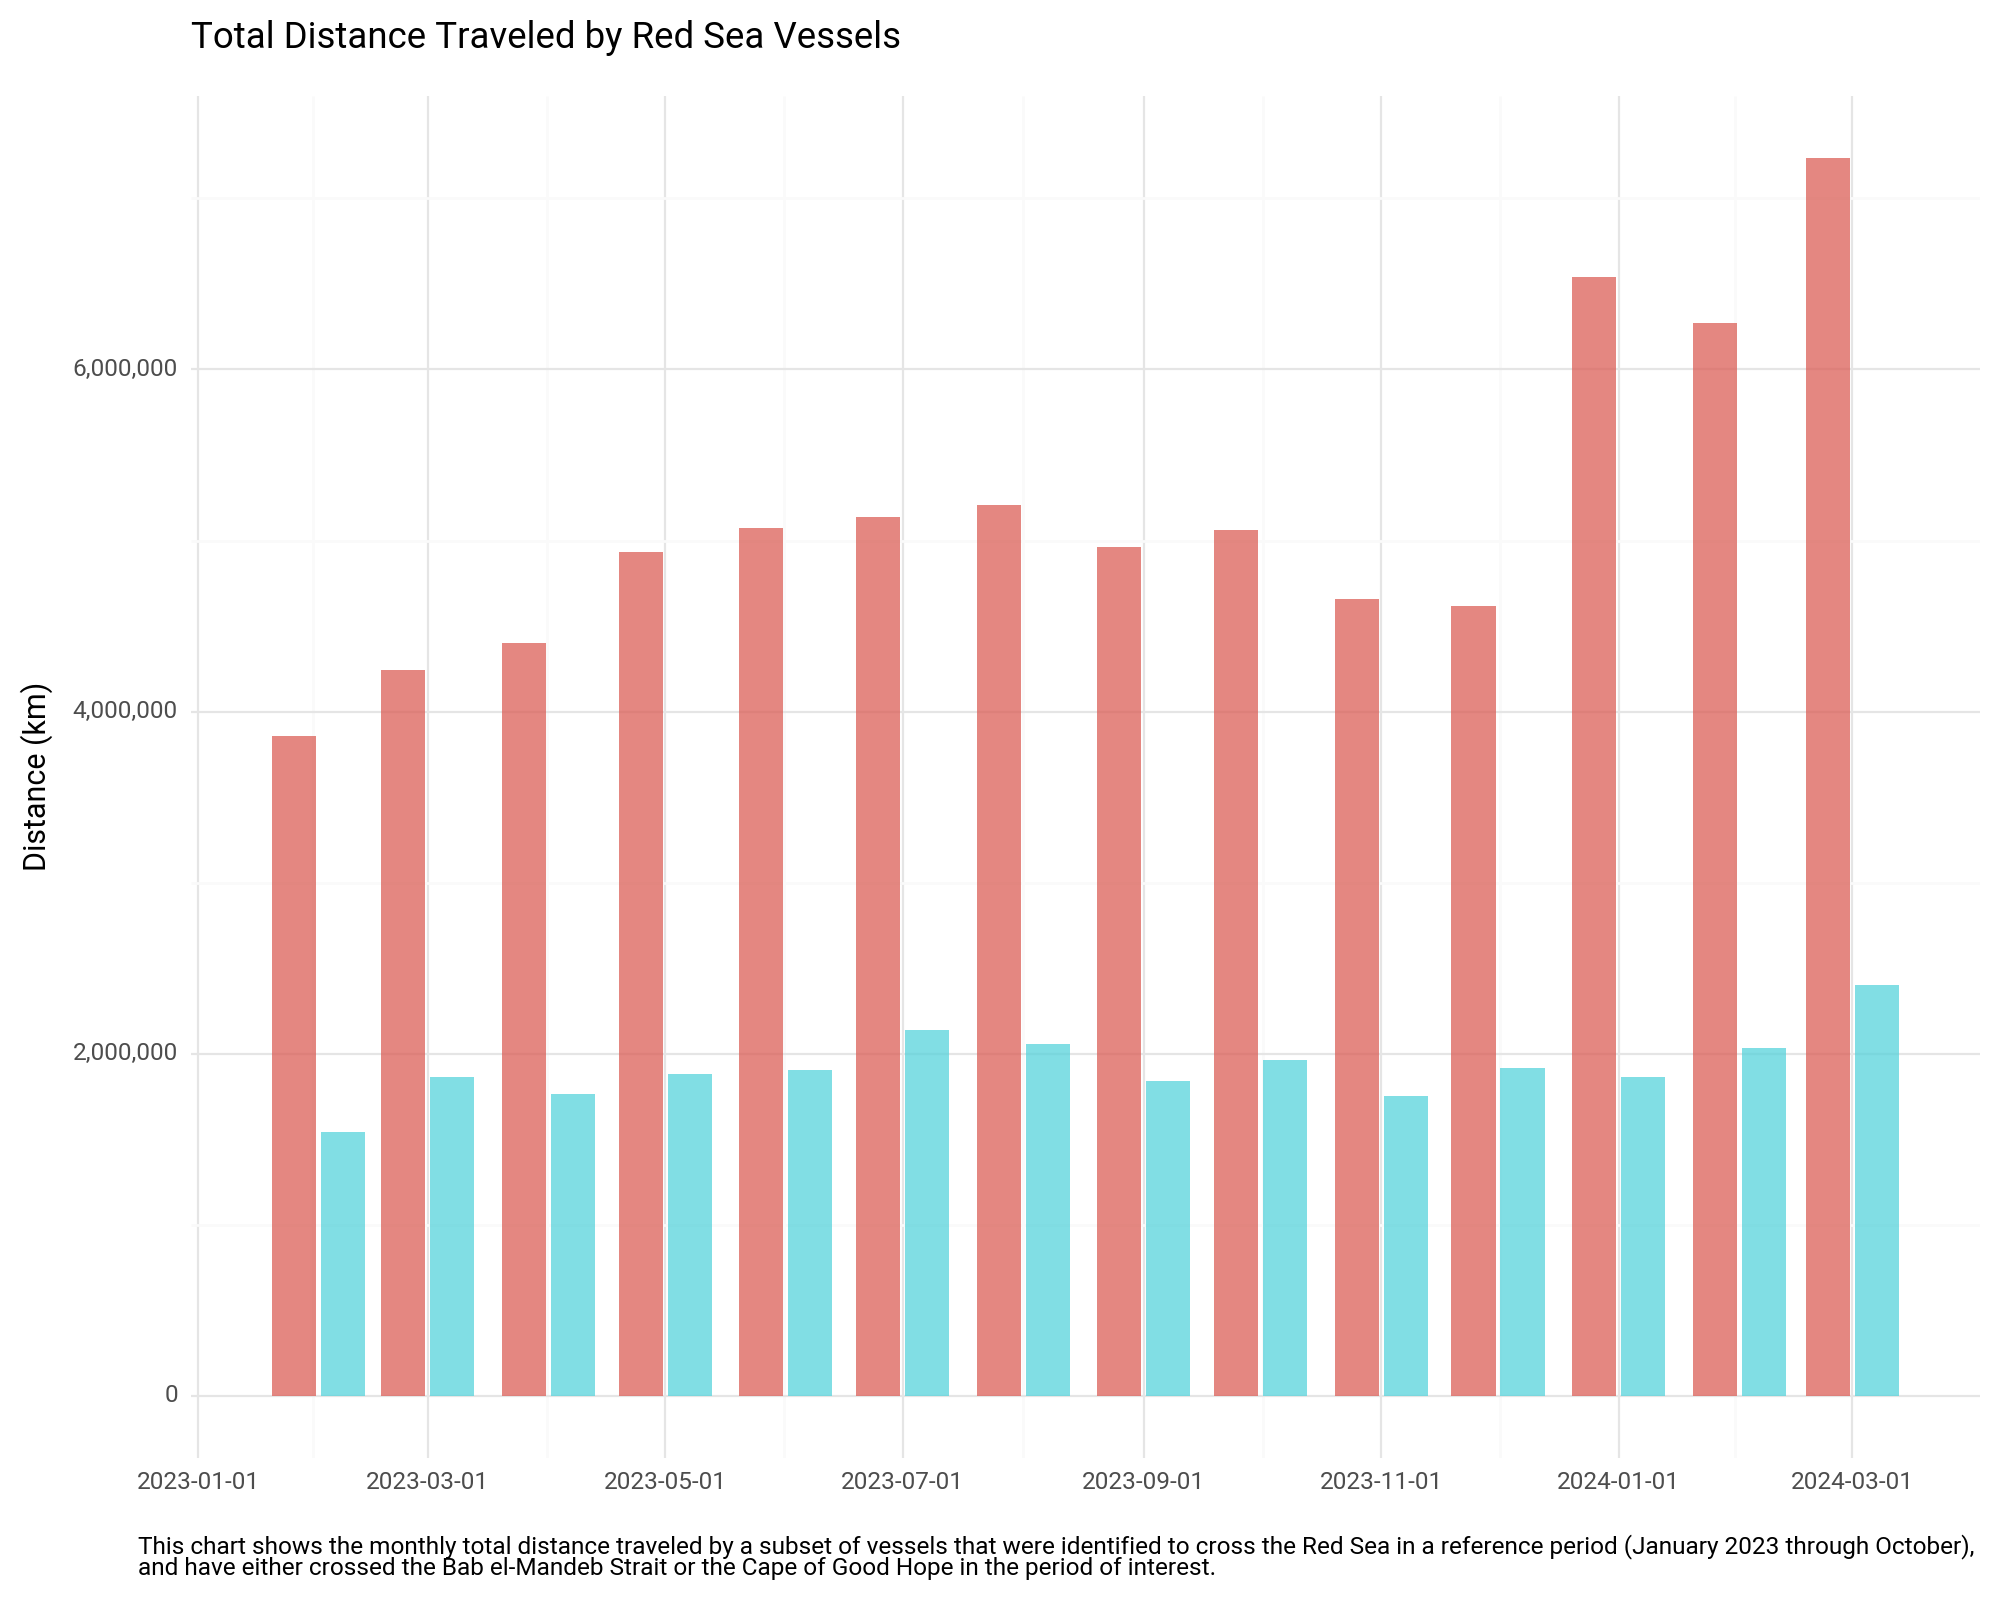

<Figure Size: (1000 x 800)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\routes\distance-traveled.jpeg


In [16]:
p0 = (
    ggplot(df_agg, aes(x="ymd", y="distance", fill="vessel_type"))  #
    + geom_bar(
        alpha=3 / 4,
        stat="identity",
        position="dodge2",
    )
    + labs(
        x="",
        y="Distance (km)",
        title=f"Total Distance Traveled by Red Sea Vessels",
        caption="This chart shows the monthly total distance traveled by a subset of vessels that were identified to cross the Red Sea in a reference period (January 2023 through October), \nand have either crossed the Bab el-Mandeb Strait or the Cape of Good Hope in the period of interest.",
    )
    + theme_minimal()
    + theme(text=element_text(family="Roboto"))
    + scale_y_continuous(labels=comma_format())
    # + scale_fill_manual(values=["#d73027", "#1a9850"])
    # + theme(axis_text_x=element_text(rotation=45, hjust=1))
    + theme(legend_position="none")
)
display(p0)
p0.save(
    filename=join(charts_dir, 'routes', f"distance-traveled.jpeg"), dpi=300
)

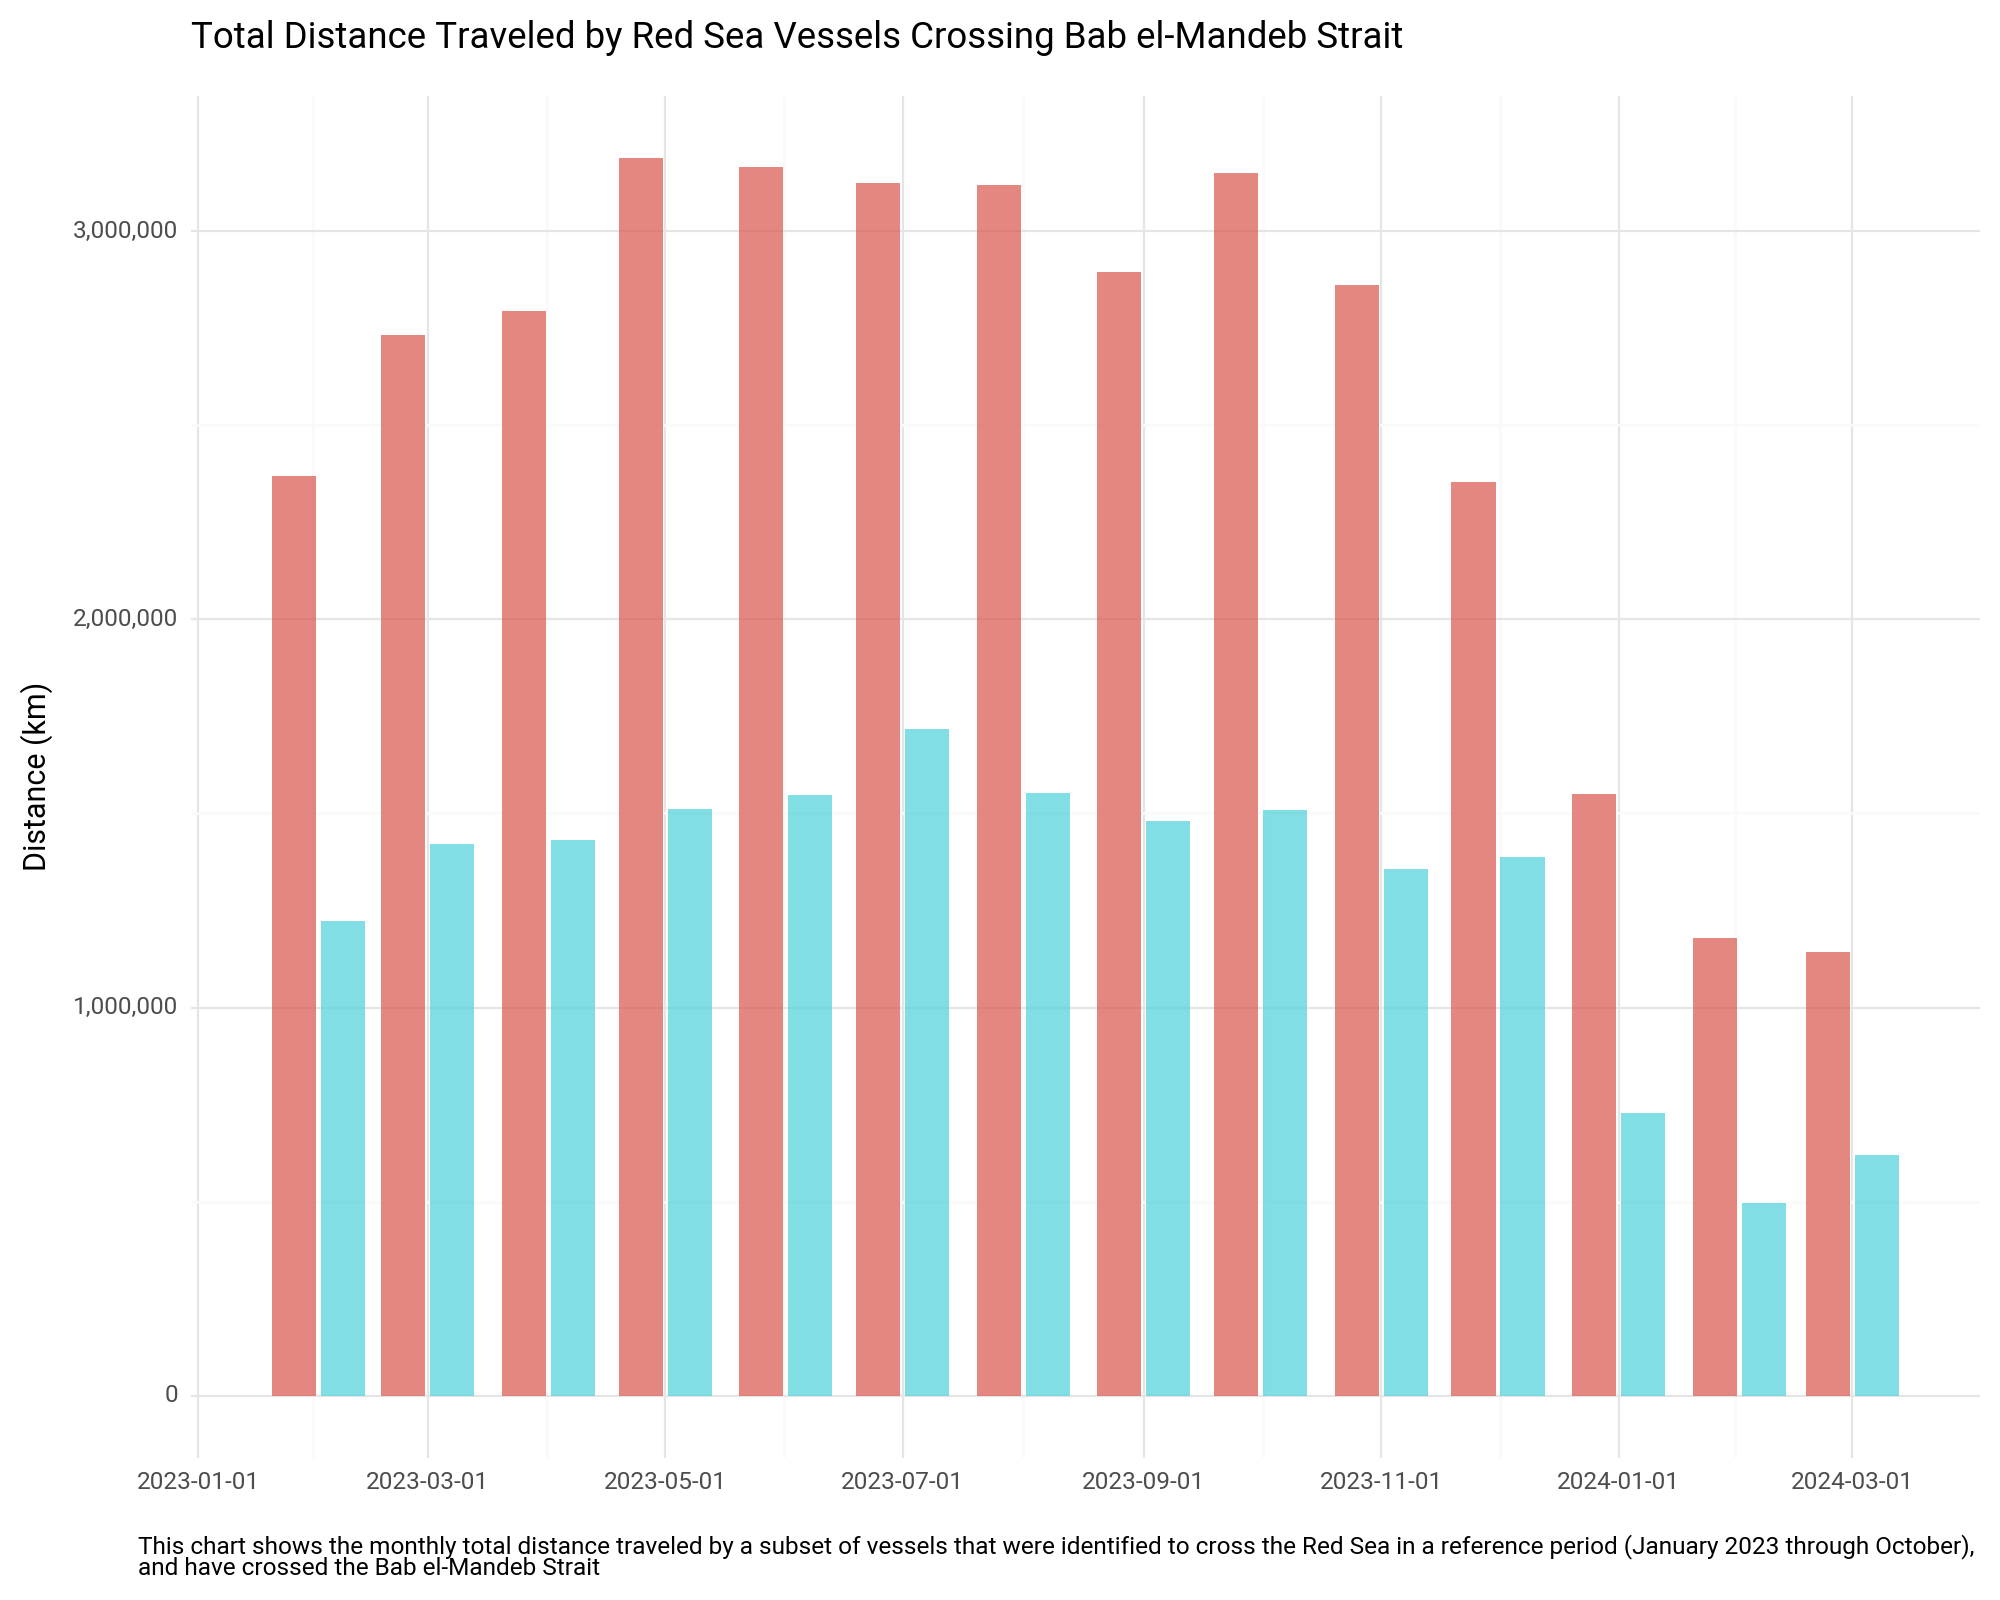

<Figure Size: (1000 x 800)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\routes\distance-traveled-bab.jpeg


In [17]:
p1 = (
    ggplot(df_agg_bab, aes(x="ymd", y="distance", fill="vessel_type"))  #
    + geom_bar(
        alpha=3 / 4,
        stat="identity",
        position="dodge2",
    )
    + labs(
        x="",
        y="Distance (km)",
        title=f"Total Distance Traveled by Red Sea Vessels Crossing Bab el-Mandeb Strait",
        caption="This chart shows the monthly total distance traveled by a subset of vessels that were identified to cross the Red Sea in a reference period (January 2023 through October), \nand have crossed the Bab el-Mandeb Strait",
    )
    + theme_minimal()
    + theme(text=element_text(family="Roboto"))
    + scale_y_continuous(labels=comma_format())
    # + scale_fill_manual(values=["#d73027", "#1a9850"])
    # + theme(axis_text_x=element_text(rotation=45, hjust=1))
    + theme(legend_position="none")
)
display(p1)
p1.save(
    filename=join(charts_dir, 'routes', f"distance-traveled-bab.jpeg"), dpi=300
)

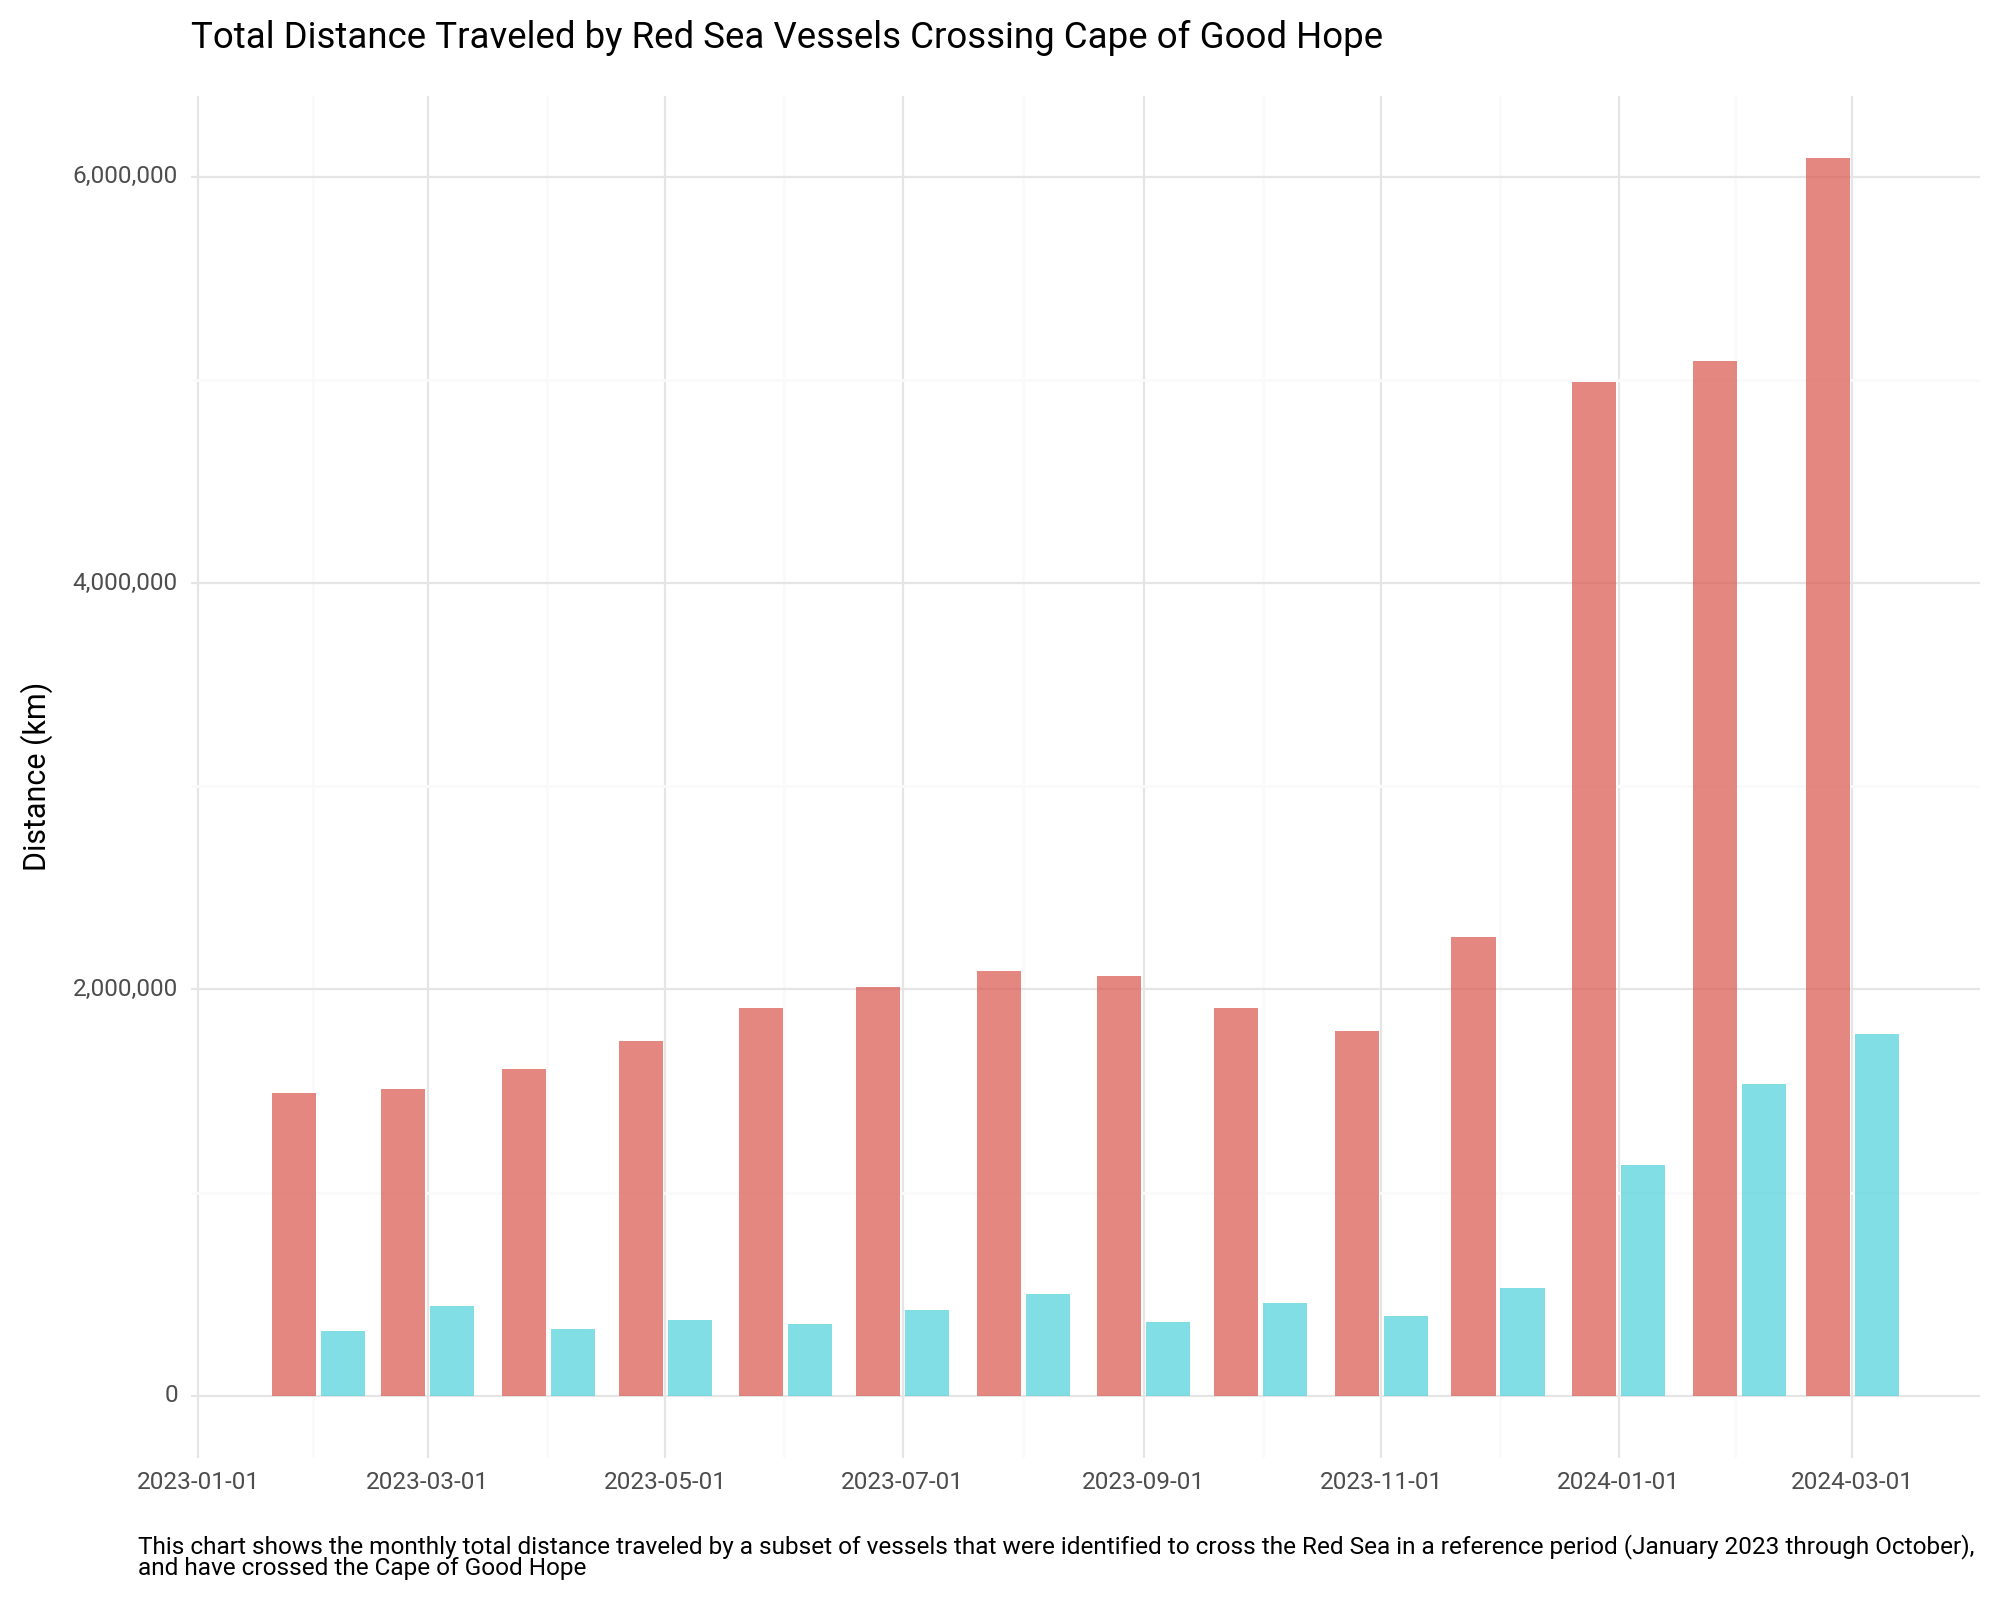

<Figure Size: (1000 x 800)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\routes\distance-traveled-cape.jpeg


In [18]:
p3 = (
    ggplot(df_agg_cape, aes(x="ymd", y="distance", fill="vessel_type"))  #
    + geom_bar(
        alpha=3 / 4,
        stat="identity",
        position="dodge2",
    )
    + labs(
        x="",
        y="Distance (km)",
        title=f"Total Distance Traveled by Red Sea Vessels Crossing Cape of Good Hope",
        caption="This chart shows the monthly total distance traveled by a subset of vessels that were identified to cross the Red Sea in a reference period (January 2023 through October), \nand have crossed the Cape of Good Hope",
    )
    + theme_minimal()
    + theme(text=element_text(family="Roboto"))
    + scale_y_continuous(labels=comma_format())
    + theme(legend_position="none")
)
display(p3)
p3.save(
    filename=join(charts_dir, 'routes', f"distance-traveled-cape.jpeg"), dpi=300
)

## Data Table

In [42]:
group_cols = ['year', 'month', 'vessel_type', 'Country', 'Port', 'prev_country', 'prev_port']
data_cols = ['time_travel', 'distance']
df_agg_od = df3.groupby(group_cols).aggregate({
    'time_travel': 'sum', 
    'distance': 'sum', 
    'unique_id': 'count'
}).reset_index()
df_agg_od.rename(columns={
    'unique_id': 'No. of Vessels',
    'prev_port': 'Previous Port',
    'prev_country': 'Previous Country',
    'vessel_type': 'Vessel Type',
    'time_travel': 'Total travel time (hrs.)',
    'distance': 'Total distance',
    'count_routes': 'No. of Vessels'
    }, inplace=True)
df_agg_od = df_agg_od[['year', 'month', 'Vessel Type', 'Previous Port', 'Previous Country', 'Country', 'Port', 'Total travel time (hrs.)', 'Total distance', 'No. of Vessels']].copy()

In [43]:
df_agg_od.head()

,year,month,Vessel Type,Previous Port,Previous Country,Country,Port,Total travel time (hrs.),Total distance,No. of Vessels
0,2023,2,Cargo,Cape of Good Hope,Chokepoint Cape of Good Hope,Angola,Luanda,338.479167,4844.855522,3
1,2023,2,Cargo,Cape of Good Hope,Chokepoint Cape of Good Hope,Argentina,Campana,1284.538333,7704.478373,2
2,2023,2,Cargo,Cape of Good Hope,Chokepoint Cape of Good Hope,Argentina,Puerto Ingeniero White,435.671389,4088.880729,1
3,2023,2,Cargo,Cape of Good Hope,Chokepoint Cape of Good Hope,Argentina,Rosario,2431.078889,23643.129837,6
4,2023,2,Cargo,Cape of Good Hope,Chokepoint Cape of Good Hope,Argentina,San Nicolas,915.360000,7837.098024,2


In [55]:
print(df_agg_od.head().to_markdown())

|    |   year |   month | Vessel Type   | Previous Port     | Previous Country             | Country   | Port                   |   Total travel time (hrs.) |   Total distance |   No. of Vessels |
|---:|-------:|--------:|:--------------|:------------------|:-----------------------------|:----------|:-----------------------|---------------------------:|-----------------:|-----------------:|
|  0 |   2023 |       2 | Cargo         | Cape of Good Hope | Chokepoint Cape of Good Hope | Angola    | Luanda                 |                    338.479 |          4844.86 |                3 |
|  1 |   2023 |       2 | Cargo         | Cape of Good Hope | Chokepoint Cape of Good Hope | Argentina | Campana                |                   1284.54  |          7704.48 |                2 |
|  2 |   2023 |       2 | Cargo         | Cape of Good Hope | Chokepoint Cape of Good Hope | Argentina | Puerto Ingeniero White |                    435.671 |          4088.88 |                1 |
|  3 |   2023 |

In [47]:
df_agg_od.to_csv(join(output_dir, 'tables', 'red-sea-distance-summary.csv'), index=False)